# Classification

## MNIST

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

print(mnist.DESCR)

/opt/conda/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [2]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [9]:
X, y = mnist.data, mnist.target

In [10]:
print(X.shape)
X[:5]

(70000, 784)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
print(y.shape)
y[:5]

(70000,)


array(['5', '0', '4', '1', '9'], dtype=object)

Digit for y[0] is 5


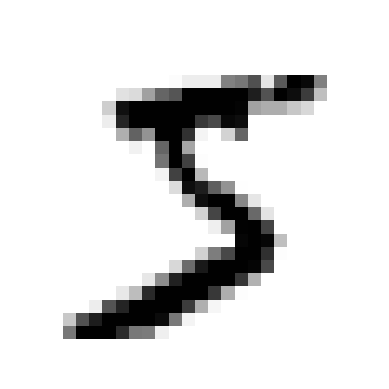

In [15]:
import numpy as np
from matplotlib import pyplot as plt

def plot_digit(image_data: np.ndarray):
    image = image_data.reshape(28, 28) # Every digit image is 28x28px
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    
some_digit = X[0]

print(f'Digit for y[0] is {y[0]}')
plot_digit(some_digit)

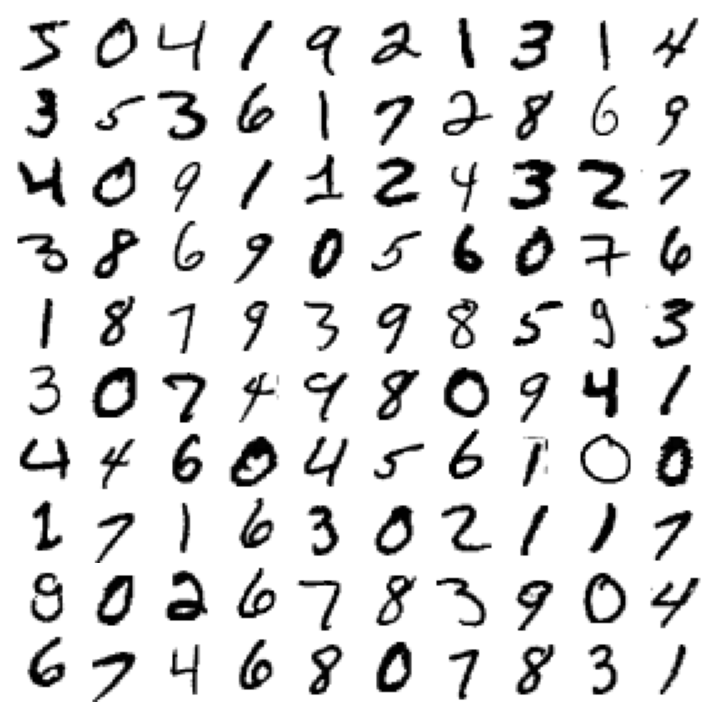

In [16]:
plt.figure(figsize=(9, 9))

for idx, img_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(img_data)

plt.subplots_adjust(wspace=0, hspace=0)

In [24]:
SLICE_SIZE = int(6e4) # 60000

X_train, X_test, y_train, y_test = X[:SLICE_SIZE], X[SLICE_SIZE:], y[:SLICE_SIZE], y[SLICE_SIZE:]

## Training a Binary Classifier

In [25]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

print('Train size', y_train_5.size)
print('Test size', y_test_5.size)

Train size 60000
Test size 10000


In [28]:
from sklearn.linear_model import SGDClassifier

SEED = 42

sgd_clf = SGDClassifier(random_state=SEED)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Follow digit image is 5:  [ True]


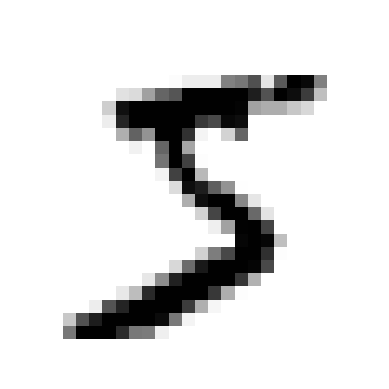

In [32]:
print(f'Follow digit image is 5: ', sgd_clf.predict([some_digit]))
plot_digit(some_digit)

## Performance Measures

In [33]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, 
                X_train, 
                y_train, 
                cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [36]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_index]
    
    y_train_folds = y_train_5[train_index]
    
    X_test_folds = X_train[test_index]
    
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    
    y_hat = clone_clf.predict(X_test_folds)
    
    n_correct = sum(y_hat == y_test_folds)
    
    print(n_correct / len(y_hat))

0.95035
0.96035
0.9604


In [37]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()

dummy_clf.fit(X_train, y_train_5)

print(any(dummy_clf.predict(X_train)))

False


In [38]:
cross_val_score(dummy_clf,
                X_train,
                y_train_5,
                cv=3,
                scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

In [39]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [40]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [41]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [42]:
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [43]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [45]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

In [48]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [49]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

In [50]:
y_scores = sgd_clf.decision_function([some_digit])

y_scores

array([2164.22030239])

In [51]:
threshold = 0

y_some_digit_pred = (y_scores > threshold)

y_some_digit_pred

array([ True])

In [53]:
threshold = 3000

y_some_digit_pred = (y_scores > threshold)

y_some_digit_pred

array([False])

In [54]:
y_scores = cross_val_predict(sgd_clf,
                             X_train,
                             y_train_5,
                             cv=3,
                             method='decision_function')

y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [55]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

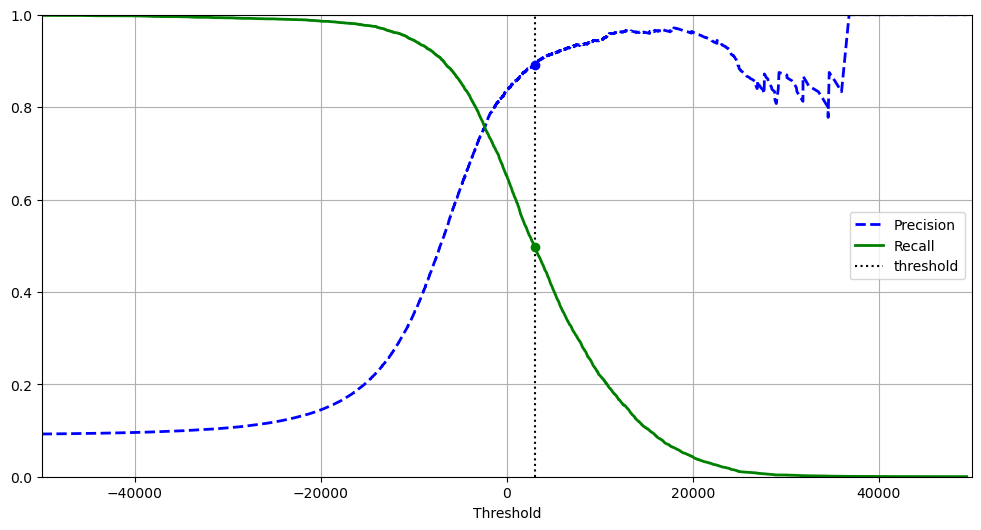

In [58]:
plt.figure(figsize=(12, 6))

plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)

plt.vlines(threshold, 0, 1.0, 'k', 'dotted', label='threshold')

idx = (thresholds >= threshold).argmax()  # first index ≥ threshold

plt.plot(thresholds[idx], precisions[idx], 'bo')
plt.plot(thresholds[idx], recalls[idx], 'go')

plt.axis([-50000, 50000, 0, 1])

plt.grid()

plt.xlabel('Threshold')
plt.legend(loc='center right')

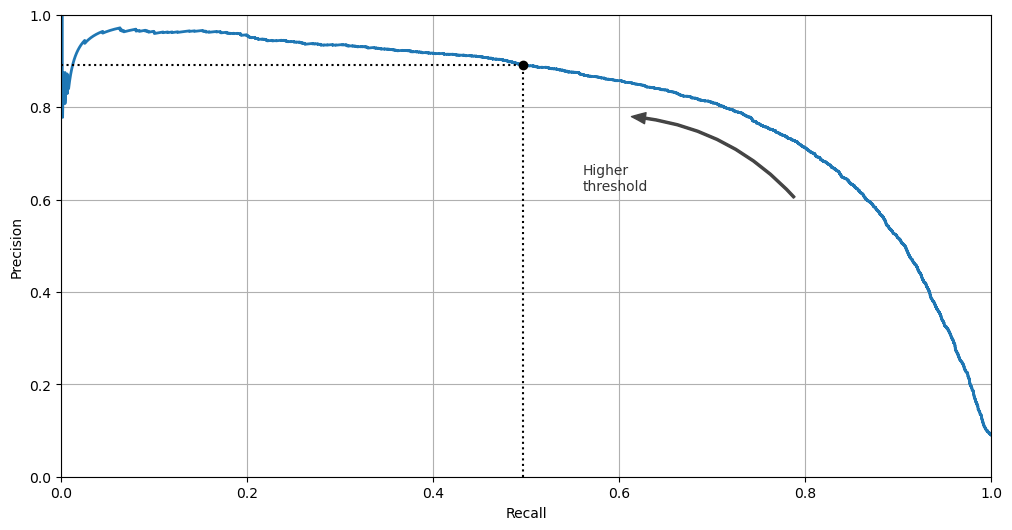

In [59]:
from matplotlib import patches

plt.figure(figsize=(12, 6))

plt.plot(recalls, precisions, linewidth=2, label='Precision/Recall curve')

plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], 'k:')
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], 'k:')
plt.plot([recalls[idx]], [precisions[idx]], 'ko',
         label='Point at threshold 3,000')

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle='arc3,rad=.2',
    arrowstyle='Simple, tail_width=1.5, head_width=8, head_length=10',
    color='#444444'))

plt.text(0.56, 0.62, 'Higher\nthreshold', color='#333333')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.axis([0, 1, 0, 1])

plt.grid()

In [60]:
idx_for_90_precision = (precisions >= .9).argmax()

threshold_for_90_precision = thresholds[idx_for_90_precision]

threshold_for_90_precision

3370.0194991439557

In [62]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [63]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)

recall_at_90_precision

0.4799852425751706

In [65]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

(0.0, 1.0, 0.0, 1.0)

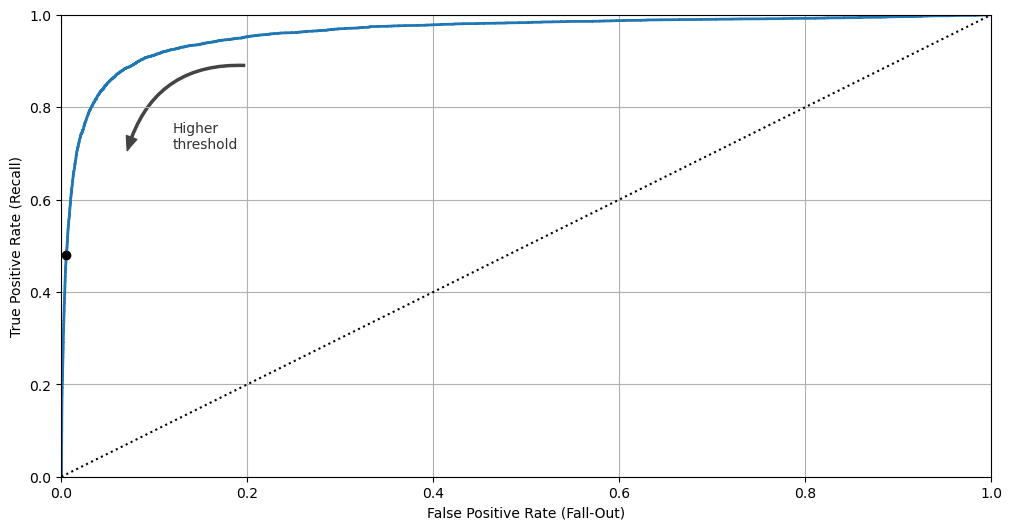

In [67]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(12, 6))

plt.plot(fpr, tpr, linewidth=2, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k:', label='Random classifier\'s ROC curve')
plt.plot([fpr_90], [tpr_90], 'ko', label='Threshold for 90% precision')

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle='arc3,rad=.4',
    arrowstyle='Simple, tail_width=1.5, head_width=8, head_length=10',
    color='#444444'))

plt.text(0.12, 0.71, 'Higher\nthreshold', color='#333333')
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')

plt.grid()

plt.axis([0, 1, 0, 1])

In [68]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [70]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=SEED)

y_proba_forest = cross_val_predict(forest_clf,
                                   X_train,
                                   y_train_5,
                                   cv=3,
                                   method='predict_proba')

y_proba_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [71]:
idx_50_to_60 = (y_proba_forest[:, 1] > .5) & (y_proba_forest[:, 1] < .6)
print(f"{(y_train_5[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}")

94.0%


In [72]:
y_scores_forest = y_proba_forest[:, 1]

precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

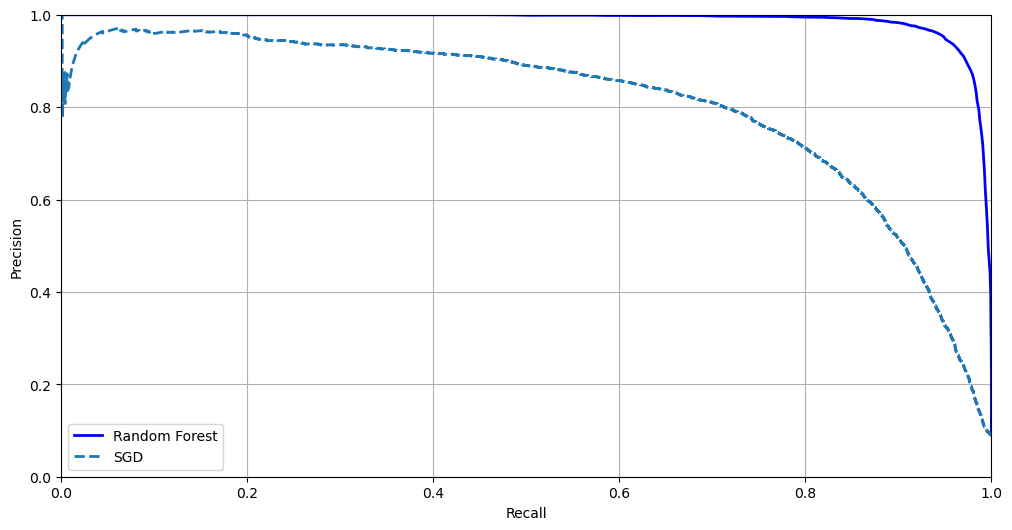

In [73]:
plt.figure(figsize=(12, 6))

plt.plot(recalls_forest, precisions_forest, 'b-', linewidth=2,
         label='Random Forest')
plt.plot(recalls, precisions, '--', linewidth=2, label='SGD')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.axis([0, 1, 0, 1])

plt.grid()

plt.legend(loc='lower left')

In [74]:
y_train_pred_forest = y_proba_forest[:, 1] >= .5
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [75]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [77]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [78]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

## Multiclass Classification

## Error Analysis

## Multilabel Classification

## Multioutput Classification